# Policy/Pi-Value/Q-Adverserial/A gradients (PQA)


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [3]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    rewards = tf.placeholder(tf.float32, [None], name='rewards') # env rewards
    rewards2 = tf.placeholder(tf.float32, [None], name='rewards2') # actions logits rewards
    rewards3 = tf.placeholder(tf.float32, [None], name='rewards3') # actions labels rewards
    return states, actions, rewards, rewards2, rewards3

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [58]:
# def model_loss(action_size, hidden_size, # model init
#                states, actions, rewards, rewards2, rewards3): # model input for G & D 
#     # policy learning/gradient
#     actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
#     actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
#     g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
#                                                                        labels=actions_labels))        
#     # log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, labels=actions_labels)        
#     # g_loss = tf.reduce_mean(-log_prob * tf.reduce_mean(rewards) * tf.reduce_mean(rewards2) * tf.reduce_mean(rewards3))
#     #g_loss = tf.reduce_mean(-log_prob * tf.reduce_mean(rewards))
#     #g_loss *= -tf.reduce_mean(rewards)
# #     g_loss *= tf.reduce_mean(rewards2) # fake/gen
# #     g_loss *= tf.reduce_mean(rewards3) # real/discr
#     g_loss *= -tf.reduce_mean(rewards2 * reward3) # fake/gen
    
#     #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, reuse=True)
#     actions_probs = tf.nn.softmax(actions_logits)
#     Qs2_logits = discriminator(actions=actions_probs, hidden_size=hidden_size, states=states) # Q=sum(rewards)
#     rewards2_logits = tf.nn.sigmoid(Qs2_logits) # total_rewards2
#     d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
#                                                                          labels=tf.reshape(rewards, shape=[-1, 1])))
# #     d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits[:-1],
# #                                                                           labels=tf.reshape(rewards2[1:], 
# #                                                                                             shape=[-1, 1])))
#     # d_loss_fake += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits[:-1],
#     #                                                                       labels=tf.reshape(rewards3[1:], 
#     #                                                                                         shape=[-1, 1])))
    
#     #actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
#     Qs3_logits = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
#     rewards3_logits = tf.nn.sigmoid(Qs3_logits) # total_rewards3
#     d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits,
#                                                                           labels=tf.reshape(rewards, shape=[-1, 1])))
# #     d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits[:-1],
# #                                                                           labels=tf.reshape(rewards3[1:], 
# #                                                                                             shape=[-1, 1])))
#     # d_loss_real += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits[:-1],
#     #                                                                       labels=tf.reshape(rewards3[1:], 
#     #                                                                                         shape=[-1, 1])))
    
#     # Returning/outputing actions, sum of rewards, rewards, and loss
#     return actions_logits, rewards2_logits, rewards3_logits, g_loss, d_loss_fake, d_loss_real

In [93]:
def model_loss(action_size, hidden_size, # model init
               states, actions, rewards, rewards2, rewards3): # model input for G & D 
    # policy learning/gradient
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    # g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
    #                                                                    labels=actions_labels))        
    #g_loss *= -tf.reduce_mean(rewards)
    #g_loss *= -tf.reduce_mean(rewards2 * reward3) # fake/gen
    log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits,labels=actions_labels)        
    #total_reward = tf.reduce_sum(rewards2) * tf.reduce_sum(reward3)
    total_reward = tf.reduce_sum(reward3)
    g_loss = tf.reduce_mean(-log_prob * total_reward)
    
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    actions_probs = tf.nn.softmax(actions_logits)
    Qs2_logits = discriminator(actions=actions_probs, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    rewards2_logits = tf.nn.sigmoid(Qs2_logits) # rewards2
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
                                                                         labels=tf.ones_like(Qs2_logits)))
    # d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
    #                                                                      labels=tf.reshape(rewards, shape=[-1, 1])))
    # d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits[:-1],
    #                                                                       labels=tf.reshape(rewards2[1:], 
    #                                                                                         shape=[-1, 1])))
    
    #actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs3_logits = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    rewards3_logits = tf.nn.sigmoid(Qs3_logits) # rewards3
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits,
                                                                         labels=tf.ones_like(Qs3_logits)))
    d_loss_real += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
                                                                          labels=tf.zeros_like(Qs3_logits)))
    # d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits,
    #                                                                       labels=tf.reshape(rewards, shape=[-1, 1])))
    # d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits[:-1],
    #                                                                       labels=tf.reshape(rewards3[1:], 
    #                                                                                         shape=[-1, 1])))
    
    # Returning/outputing actions, sum of rewards, rewards, and loss
    return actions_logits, rewards2_logits, rewards3_logits, g_loss, d_loss_fake, d_loss_real

In [94]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss_fake, d_loss_real, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss_fake: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param d_loss_real: Discriminator loss Tensor for reward prediction for env/onehot/labels action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss+d_loss_fake, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss_real, var_list=d_vars)
        gd_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss_fake, var_list=g_vars)

    return g_opt, d_opt, gd_opt

In [95]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.rewards, self.rewards2, self.rewards3 = model_input(state_size=state_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.rewards2_logits, self.rewards3_logits, self.g_loss, self.d_loss_fake, self.d_loss_real = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init 
            actions=self.actions, states=self.states, # model input
            rewards=self.rewards, rewards2=self.rewards2, rewards3=self.rewards3) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt, self.gd_opt = model_opt(g_loss=self.g_loss, 
                                                        d_loss_fake=self.d_loss_fake,
                                                        d_loss_real=self.d_loss_real,
                                                        learning_rate=learning_rate)

In [96]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [97]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

In [99]:
# Now train with experiences
saver = tf.train.Saver()
# t_vars = tf.trainable_variables()
# g_vars = [var for var in t_vars if var.name.startswith('generator')]
# d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
# saver = tf.train.Saver(var_list=d_vars)
# saver = tf.train.Saver(var_list=g_vars) # train D
# saver = tf.train.Saver(var_list=t_vars)

# Env reward, action logits reward, action labels/onehot reward
rewards_list, rewards2_list, rewards3_list, g_loss_list, d_loss_fake_list, d_loss_real_list = [], [], [], [], [], []

# TF session for training
with tf.Session() as sess:
    
    # Rstoring/loading the trained/learned controller SA/SM
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-g.ckpt') 
    #saver.restore(sess, 'checkpoints/model-g-d.ckpt') 
    #saver.save(sess, 'checkpoints/model-g-d2.ckpt')
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0 # reward env
        total_reward2 = 0 # reward action logits
        total_reward3 = 0 # reward action onehot/labels

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits = sess.run([model.actions_logits], feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            reward2, reward3 = sess.run([model.rewards2_logits, model.rewards3_logits],
                                        feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                   model.actions: np.array([action])})
            total_reward += reward # env
            total_reward2 += reward2[0, 0] #_action_logits
            total_reward3 += reward3[0, 0] #_actions_labels
            # state & action pair for policy learning: current policy/action
            # reward for adverserial/reward learning: current reward/value
            # reward2 and reward3 for value/Q learning: future rewards/value
            batch.append([state, action, reward, reward2[0, 0], reward3[0, 0]])
            state = next_state
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        rewards2 = np.array([each[3] for each in batch])
        rewards3 = np.array([each[4] for each in batch])
#         g_loss, _ = sess.run([model.g_loss, model.g_opt], 
#                              feed_dict = {model.states: states,
#                                           model.actions: actions, 
#                                           model.rewards:rewards, 
#                                           model.rewards2:rewards2, 
#                                           model.rewards3:rewards3})
#         d_loss_real, _ = sess.run([model.d_loss_real, model.d_opt], 
#                                   feed_dict = {model.states: states,
#                                                model.actions: actions, 
#                                                model.rewards:rewards, 
#                                                model.rewards2:rewards2, 
#                                                model.rewards3:rewards3})
# #         d_loss_fake = sess.run(model.d_loss_fake,
# #                                feed_dict = {model.states: states,
# #                                             model.actions: actions, 
# #                                             model.rewards:rewards, 
# #                                             model.rewards2:rewards2, 
# #                                             model.rewards3:rewards3})
#         d_loss_fake, _ = sess.run([model.d_loss_fake, model.gd_opt], 
#                              feed_dict = {model.states: states,
#                                           model.actions: actions, 
#                                           model.rewards:rewards, 
#                                           model.rewards2:rewards2, 
#                                           model.rewards3:rewards3})
        g_loss, d_loss_fake, d_loss_real, _, _ = sess.run([model.g_loss, model.d_loss_fake, model.d_loss_real,
                                                           model.g_opt, model.d_opt], 
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions, 
                                                                       model.rewards:rewards, 
                                                                       model.rewards2:rewards2,
                                                                       model.rewards3:rewards3})
        print('Episode: {}'.format(ep),
              'total_reward: {}'.format(total_reward),
              'total_reward2: {:.4f}'.format(total_reward2),
              'total_reward3: {:.4f}'.format(total_reward3),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss_fake: {:.4f}'.format(d_loss_fake),
              'd_loss_real: {:.4f}'.format(d_loss_real))
        rewards_list.append([ep, total_reward])
        rewards2_list.append([ep, total_reward2])
        rewards3_list.append([ep, total_reward3])
        g_loss_list.append([ep, g_loss])
        d_loss_fake_list.append([ep, d_loss_fake])
        d_loss_real_list.append([ep, d_loss_real])
        
    # Save the trained/learned D using G/SM/SA
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pqa.ckpt')
    #saver.save(sess, tf.train.latest_checkpoint('checkpoints'))

Episode: 0 total_reward: 19.0 total_reward2: 10.1529 total_reward3: 10.1161 g_loss: -0.3455 d_loss_fake: 0.6268 d_loss_real: 1.3954
Episode: 1 total_reward: 9.0 total_reward2: 4.9136 total_reward3: 4.8684 g_loss: -0.3378 d_loss_fake: 0.6065 d_loss_real: 1.4072
Episode: 2 total_reward: 25.0 total_reward2: 12.4534 total_reward3: 12.7226 g_loss: -0.3410 d_loss_fake: 0.6969 d_loss_real: 1.3652
Episode: 3 total_reward: 19.0 total_reward2: 9.3724 total_reward3: 9.6152 g_loss: -0.3421 d_loss_fake: 0.7067 d_loss_real: 1.3611
Episode: 4 total_reward: 16.0 total_reward2: 7.7652 total_reward3: 8.0313 g_loss: -0.3433 d_loss_fake: 0.7229 d_loss_real: 1.3537
Episode: 5 total_reward: 15.0 total_reward2: 7.2451 total_reward3: 7.4309 g_loss: -0.3433 d_loss_fake: 0.7277 d_loss_real: 1.3624
Episode: 6 total_reward: 9.0 total_reward2: 4.3066 total_reward3: 4.4512 g_loss: -0.3397 d_loss_fake: 0.7371 d_loss_real: 1.3557
Episode: 7 total_reward: 13.0 total_reward2: 6.2596 total_reward3: 6.5068 g_loss: -0.343

Episode: 68 total_reward: 17.0 total_reward2: 5.6036 total_reward3: 11.5282 g_loss: -0.3441 d_loss_fake: 1.1102 d_loss_real: 0.7903
Episode: 69 total_reward: 18.0 total_reward2: 5.8070 total_reward3: 12.4305 g_loss: -0.3450 d_loss_fake: 1.1323 d_loss_real: 0.7613
Episode: 70 total_reward: 23.0 total_reward2: 7.1952 total_reward3: 16.0404 g_loss: -0.3447 d_loss_fake: 1.1625 d_loss_real: 0.7371
Episode: 71 total_reward: 16.0 total_reward2: 5.0680 total_reward3: 11.1854 g_loss: -0.3453 d_loss_fake: 1.1508 d_loss_real: 0.7417
Episode: 72 total_reward: 9.0 total_reward2: 2.8604 total_reward3: 6.6261 g_loss: -0.3419 d_loss_fake: 1.1467 d_loss_real: 0.6888
Episode: 73 total_reward: 15.0 total_reward2: 4.8326 total_reward3: 11.0972 g_loss: -0.3388 d_loss_fake: 1.1335 d_loss_real: 0.6906
Episode: 74 total_reward: 14.0 total_reward2: 5.0431 total_reward3: 10.0605 g_loss: -0.3454 d_loss_fake: 1.0239 d_loss_real: 0.7787
Episode: 75 total_reward: 23.0 total_reward2: 7.0088 total_reward3: 17.0448 g_

Episode: 138 total_reward: 8.0 total_reward2: 3.9437 total_reward3: 3.9715 g_loss: -0.0006 d_loss_fake: 0.7074 d_loss_real: 1.3799
Episode: 139 total_reward: 9.0 total_reward2: 4.4311 total_reward3: 4.4649 g_loss: -0.0007 d_loss_fake: 0.7087 d_loss_real: 1.3793
Episode: 140 total_reward: 10.0 total_reward2: 4.9279 total_reward3: 4.9607 g_loss: -0.0006 d_loss_fake: 0.7079 d_loss_real: 1.3803
Episode: 141 total_reward: 10.0 total_reward2: 4.9809 total_reward3: 5.0144 g_loss: -0.0006 d_loss_fake: 0.6972 d_loss_real: 1.3802
Episode: 142 total_reward: 9.0 total_reward2: 4.5331 total_reward3: 4.5594 g_loss: -0.0006 d_loss_fake: 0.6861 d_loss_real: 1.3812
Episode: 143 total_reward: 9.0 total_reward2: 4.4956 total_reward3: 4.5204 g_loss: -0.0005 d_loss_fake: 0.6944 d_loss_real: 1.3814
Episode: 144 total_reward: 8.0 total_reward2: 3.9830 total_reward3: 4.0080 g_loss: -0.0006 d_loss_fake: 0.6976 d_loss_real: 1.3805
Episode: 145 total_reward: 10.0 total_reward2: 4.9611 total_reward3: 4.9854 g_los

Episode: 210 total_reward: 10.0 total_reward2: 4.9898 total_reward3: 4.9990 g_loss: -0.0002 d_loss_fake: 0.6952 d_loss_real: 1.3845
Episode: 211 total_reward: 10.0 total_reward2: 5.0097 total_reward3: 5.0182 g_loss: -0.0002 d_loss_fake: 0.6912 d_loss_real: 1.3846
Episode: 212 total_reward: 10.0 total_reward2: 5.0097 total_reward3: 5.0197 g_loss: -0.0002 d_loss_fake: 0.6912 d_loss_real: 1.3843
Episode: 213 total_reward: 9.0 total_reward2: 4.5068 total_reward3: 4.5161 g_loss: -0.0002 d_loss_fake: 0.6916 d_loss_real: 1.3843
Episode: 214 total_reward: 9.0 total_reward2: 4.4968 total_reward3: 4.5054 g_loss: -0.0002 d_loss_fake: 0.6939 d_loss_real: 1.3844
Episode: 215 total_reward: 10.0 total_reward2: 4.9850 total_reward3: 4.9930 g_loss: -0.0001 d_loss_fake: 0.6962 d_loss_real: 1.3847
Episode: 216 total_reward: 9.0 total_reward2: 4.4822 total_reward3: 4.4905 g_loss: -0.0002 d_loss_fake: 0.6971 d_loss_real: 1.3845
Episode: 217 total_reward: 10.0 total_reward2: 4.9854 total_reward3: 4.9933 g_l

Episode: 273 total_reward: 10.0 total_reward2: 4.9925 total_reward3: 4.9969 g_loss: -0.0001 d_loss_fake: 0.6946 d_loss_real: 1.3854
Episode: 274 total_reward: 11.0 total_reward2: 5.4805 total_reward3: 5.4873 g_loss: -0.0001 d_loss_fake: 0.6967 d_loss_real: 1.3851
Episode: 275 total_reward: 9.0 total_reward2: 4.4988 total_reward3: 4.5039 g_loss: -0.0001 d_loss_fake: 0.6934 d_loss_real: 1.3852
Episode: 276 total_reward: 10.0 total_reward2: 5.0063 total_reward3: 5.0108 g_loss: -0.0001 d_loss_fake: 0.6919 d_loss_real: 1.3854
Episode: 277 total_reward: 8.0 total_reward2: 4.0080 total_reward3: 4.0129 g_loss: -0.0001 d_loss_fake: 0.6912 d_loss_real: 1.3851
Episode: 278 total_reward: 8.0 total_reward2: 4.0036 total_reward3: 4.0069 g_loss: -0.0001 d_loss_fake: 0.6922 d_loss_real: 1.3855
Episode: 279 total_reward: 10.0 total_reward2: 4.9768 total_reward3: 4.9819 g_loss: -0.0001 d_loss_fake: 0.6978 d_loss_real: 1.3853
Episode: 280 total_reward: 10.0 total_reward2: 4.9858 total_reward3: 4.9904 g_l

Episode: 337 total_reward: 10.0 total_reward2: 5.0024 total_reward3: 5.0053 g_loss: -0.0001 d_loss_fake: 0.6927 d_loss_real: 1.3857
Episode: 338 total_reward: 10.0 total_reward2: 5.0056 total_reward3: 5.0079 g_loss: -0.0000 d_loss_fake: 0.6920 d_loss_real: 1.3858
Episode: 339 total_reward: 9.0 total_reward2: 4.5034 total_reward3: 4.5059 g_loss: -0.0001 d_loss_fake: 0.6924 d_loss_real: 1.3857
Episode: 340 total_reward: 10.0 total_reward2: 4.9846 total_reward3: 4.9878 g_loss: -0.0001 d_loss_fake: 0.6962 d_loss_real: 1.3857
Episode: 341 total_reward: 8.0 total_reward2: 4.0000 total_reward3: 4.0028 g_loss: -0.0001 d_loss_fake: 0.6931 d_loss_real: 1.3856
Episode: 342 total_reward: 10.0 total_reward2: 4.9953 total_reward3: 4.9995 g_loss: -0.0001 d_loss_fake: 0.6941 d_loss_real: 1.3855
Episode: 343 total_reward: 10.0 total_reward2: 5.0004 total_reward3: 5.0038 g_loss: -0.0001 d_loss_fake: 0.6931 d_loss_real: 1.3856
Episode: 344 total_reward: 10.0 total_reward2: 5.0171 total_reward3: 5.0194 g_

Episode: 401 total_reward: 10.0 total_reward2: 5.0049 total_reward3: 5.0073 g_loss: -0.0000 d_loss_fake: 0.6922 d_loss_real: 1.3858
Episode: 402 total_reward: 8.0 total_reward2: 3.9992 total_reward3: 4.0008 g_loss: -0.0000 d_loss_fake: 0.6934 d_loss_real: 1.3859
Episode: 403 total_reward: 9.0 total_reward2: 4.4990 total_reward3: 4.5005 g_loss: -0.0000 d_loss_fake: 0.6934 d_loss_real: 1.3860
Episode: 404 total_reward: 9.0 total_reward2: 4.4922 total_reward3: 4.4938 g_loss: -0.0000 d_loss_fake: 0.6949 d_loss_real: 1.3859
Episode: 405 total_reward: 10.0 total_reward2: 4.9952 total_reward3: 4.9976 g_loss: -0.0000 d_loss_fake: 0.6941 d_loss_real: 1.3858
Episode: 406 total_reward: 8.0 total_reward2: 4.0047 total_reward3: 4.0064 g_loss: -0.0000 d_loss_fake: 0.6920 d_loss_real: 1.3859
Episode: 407 total_reward: 10.0 total_reward2: 5.0061 total_reward3: 5.0081 g_loss: -0.0000 d_loss_fake: 0.6919 d_loss_real: 1.3859
Episode: 408 total_reward: 9.0 total_reward2: 4.4961 total_reward3: 4.4983 g_los

Episode: 464 total_reward: 10.0 total_reward2: 4.9929 total_reward3: 4.9943 g_loss: -0.0000 d_loss_fake: 0.6946 d_loss_real: 1.3860
Episode: 465 total_reward: 9.0 total_reward2: 4.4962 total_reward3: 4.4980 g_loss: -0.0000 d_loss_fake: 0.6940 d_loss_real: 1.3859
Episode: 466 total_reward: 10.0 total_reward2: 5.0049 total_reward3: 5.0062 g_loss: -0.0000 d_loss_fake: 0.6922 d_loss_real: 1.3860
Episode: 467 total_reward: 9.0 total_reward2: 4.5051 total_reward3: 4.5066 g_loss: -0.0000 d_loss_fake: 0.6920 d_loss_real: 1.3860
Episode: 468 total_reward: 10.0 total_reward2: 4.9941 total_reward3: 4.9960 g_loss: -0.0000 d_loss_fake: 0.6943 d_loss_real: 1.3859
Episode: 469 total_reward: 10.0 total_reward2: 4.9960 total_reward3: 4.9972 g_loss: -0.0000 d_loss_fake: 0.6940 d_loss_real: 1.3861
Episode: 470 total_reward: 10.0 total_reward2: 5.0027 total_reward3: 5.0048 g_loss: -0.0000 d_loss_fake: 0.6926 d_loss_real: 1.3859
Episode: 471 total_reward: 9.0 total_reward2: 4.5094 total_reward3: 4.5104 g_l

Episode: 531 total_reward: 9.0 total_reward2: 4.4981 total_reward3: 4.4992 g_loss: -0.0000 d_loss_fake: 0.6936 d_loss_real: 1.3861
Episode: 532 total_reward: 9.0 total_reward2: 4.5006 total_reward3: 4.5019 g_loss: -0.0000 d_loss_fake: 0.6930 d_loss_real: 1.3860
Episode: 533 total_reward: 10.0 total_reward2: 4.9973 total_reward3: 4.9987 g_loss: -0.0000 d_loss_fake: 0.6937 d_loss_real: 1.3860
Episode: 534 total_reward: 9.0 total_reward2: 4.4967 total_reward3: 4.4981 g_loss: -0.0000 d_loss_fake: 0.6939 d_loss_real: 1.3860
Episode: 535 total_reward: 10.0 total_reward2: 4.9947 total_reward3: 4.9963 g_loss: -0.0000 d_loss_fake: 0.6942 d_loss_real: 1.3860
Episode: 536 total_reward: 10.0 total_reward2: 5.0045 total_reward3: 5.0053 g_loss: -0.0000 d_loss_fake: 0.6923 d_loss_real: 1.3861
Episode: 537 total_reward: 9.0 total_reward2: 4.5024 total_reward3: 4.5036 g_loss: -0.0000 d_loss_fake: 0.6926 d_loss_real: 1.3860
Episode: 538 total_reward: 8.0 total_reward2: 3.9993 total_reward3: 4.0006 g_los

Episode: 595 total_reward: 10.0 total_reward2: 4.9860 total_reward3: 4.9868 g_loss: -0.0000 d_loss_fake: 0.6959 d_loss_real: 1.3861
Episode: 596 total_reward: 10.0 total_reward2: 4.9966 total_reward3: 4.9975 g_loss: -0.0000 d_loss_fake: 0.6938 d_loss_real: 1.3861
Episode: 597 total_reward: 8.0 total_reward2: 4.0114 total_reward3: 4.0121 g_loss: -0.0000 d_loss_fake: 0.6903 d_loss_real: 1.3861
Episode: 598 total_reward: 9.0 total_reward2: 4.5073 total_reward3: 4.5083 g_loss: -0.0000 d_loss_fake: 0.6915 d_loss_real: 1.3861
Episode: 599 total_reward: 10.0 total_reward2: 4.9852 total_reward3: 4.9864 g_loss: -0.0000 d_loss_fake: 0.6961 d_loss_real: 1.3861
Episode: 600 total_reward: 9.0 total_reward2: 4.4901 total_reward3: 4.4911 g_loss: -0.0000 d_loss_fake: 0.6953 d_loss_real: 1.3861
Episode: 601 total_reward: 9.0 total_reward2: 4.5017 total_reward3: 4.5028 g_loss: -0.0000 d_loss_fake: 0.6928 d_loss_real: 1.3861
Episode: 602 total_reward: 8.0 total_reward2: 4.0054 total_reward3: 4.0062 g_los

Episode: 658 total_reward: 8.0 total_reward2: 4.0052 total_reward3: 4.0058 g_loss: -0.0000 d_loss_fake: 0.6919 d_loss_real: 1.3861
Episode: 659 total_reward: 10.0 total_reward2: 5.0065 total_reward3: 5.0070 g_loss: -0.0000 d_loss_fake: 0.6918 d_loss_real: 1.3862
Episode: 660 total_reward: 9.0 total_reward2: 4.4892 total_reward3: 4.4901 g_loss: -0.0000 d_loss_fake: 0.6955 d_loss_real: 1.3861
Episode: 661 total_reward: 10.0 total_reward2: 4.9918 total_reward3: 4.9924 g_loss: -0.0000 d_loss_fake: 0.6948 d_loss_real: 1.3862
Episode: 662 total_reward: 9.0 total_reward2: 4.5019 total_reward3: 4.5027 g_loss: -0.0000 d_loss_fake: 0.6927 d_loss_real: 1.3861
Episode: 663 total_reward: 10.0 total_reward2: 5.0068 total_reward3: 5.0077 g_loss: -0.0000 d_loss_fake: 0.6918 d_loss_real: 1.3861
Episode: 664 total_reward: 9.0 total_reward2: 4.5044 total_reward3: 4.5051 g_loss: -0.0000 d_loss_fake: 0.6922 d_loss_real: 1.3861
Episode: 665 total_reward: 9.0 total_reward2: 4.4937 total_reward3: 4.4944 g_los

Episode: 722 total_reward: 8.0 total_reward2: 4.0036 total_reward3: 4.0040 g_loss: -0.0000 d_loss_fake: 0.6923 d_loss_real: 1.3862
Episode: 723 total_reward: 11.0 total_reward2: 5.4998 total_reward3: 5.5004 g_loss: -0.0000 d_loss_fake: 0.6932 d_loss_real: 1.3862
Episode: 724 total_reward: 9.0 total_reward2: 4.5005 total_reward3: 4.5011 g_loss: -0.0000 d_loss_fake: 0.6930 d_loss_real: 1.3862
Episode: 725 total_reward: 10.0 total_reward2: 5.0007 total_reward3: 5.0013 g_loss: -0.0000 d_loss_fake: 0.6930 d_loss_real: 1.3862
Episode: 726 total_reward: 10.0 total_reward2: 4.9991 total_reward3: 4.9998 g_loss: -0.0000 d_loss_fake: 0.6933 d_loss_real: 1.3862
Episode: 727 total_reward: 10.0 total_reward2: 4.9955 total_reward3: 4.9963 g_loss: -0.0000 d_loss_fake: 0.6940 d_loss_real: 1.3861
Episode: 728 total_reward: 10.0 total_reward2: 5.0035 total_reward3: 5.0043 g_loss: -0.0000 d_loss_fake: 0.6925 d_loss_real: 1.3861
Episode: 729 total_reward: 10.0 total_reward2: 5.0042 total_reward3: 5.0046 g_

Episode: 794 total_reward: 9.0 total_reward2: 4.4994 total_reward3: 4.4999 g_loss: -0.0000 d_loss_fake: 0.6933 d_loss_real: 1.3862
Episode: 795 total_reward: 11.0 total_reward2: 5.4885 total_reward3: 5.4891 g_loss: -0.0000 d_loss_fake: 0.6952 d_loss_real: 1.3862
Episode: 796 total_reward: 10.0 total_reward2: 5.0053 total_reward3: 5.0059 g_loss: -0.0000 d_loss_fake: 0.6921 d_loss_real: 1.3862
Episode: 797 total_reward: 8.0 total_reward2: 4.0060 total_reward3: 4.0063 g_loss: -0.0000 d_loss_fake: 0.6916 d_loss_real: 1.3862
Episode: 798 total_reward: 10.0 total_reward2: 4.9944 total_reward3: 4.9949 g_loss: -0.0000 d_loss_fake: 0.6943 d_loss_real: 1.3862
Episode: 799 total_reward: 10.0 total_reward2: 5.0011 total_reward3: 5.0014 g_loss: -0.0000 d_loss_fake: 0.6929 d_loss_real: 1.3862
Episode: 800 total_reward: 9.0 total_reward2: 4.4971 total_reward3: 4.4974 g_loss: -0.0000 d_loss_fake: 0.6938 d_loss_real: 1.3862
Episode: 801 total_reward: 8.0 total_reward2: 3.9988 total_reward3: 3.9991 g_lo

Episode: 858 total_reward: 9.0 total_reward2: 4.4895 total_reward3: 4.4899 g_loss: -0.0000 d_loss_fake: 0.6955 d_loss_real: 1.3862
Episode: 859 total_reward: 9.0 total_reward2: 4.5066 total_reward3: 4.5069 g_loss: -0.0000 d_loss_fake: 0.6917 d_loss_real: 1.3862
Episode: 860 total_reward: 10.0 total_reward2: 5.0090 total_reward3: 5.0093 g_loss: -0.0000 d_loss_fake: 0.6914 d_loss_real: 1.3862
Episode: 861 total_reward: 10.0 total_reward2: 5.0031 total_reward3: 5.0034 g_loss: -0.0000 d_loss_fake: 0.6925 d_loss_real: 1.3862
Episode: 862 total_reward: 9.0 total_reward2: 4.4849 total_reward3: 4.4853 g_loss: -0.0000 d_loss_fake: 0.6965 d_loss_real: 1.3862
Episode: 863 total_reward: 9.0 total_reward2: 4.4991 total_reward3: 4.4995 g_loss: -0.0000 d_loss_fake: 0.6933 d_loss_real: 1.3862
Episode: 864 total_reward: 9.0 total_reward2: 4.5093 total_reward3: 4.5097 g_loss: -0.0000 d_loss_fake: 0.6911 d_loss_real: 1.3862
Episode: 865 total_reward: 9.0 total_reward2: 4.5035 total_reward3: 4.5037 g_loss

Episode: 922 total_reward: 9.0 total_reward2: 4.4882 total_reward3: 4.4885 g_loss: -0.0000 d_loss_fake: 0.6958 d_loss_real: 1.3862
Episode: 923 total_reward: 8.0 total_reward2: 4.0023 total_reward3: 4.0025 g_loss: -0.0000 d_loss_fake: 0.6926 d_loss_real: 1.3862
Episode: 924 total_reward: 10.0 total_reward2: 5.0112 total_reward3: 5.0114 g_loss: -0.0000 d_loss_fake: 0.6909 d_loss_real: 1.3862
Episode: 925 total_reward: 10.0 total_reward2: 4.9891 total_reward3: 4.9894 g_loss: -0.0000 d_loss_fake: 0.6953 d_loss_real: 1.3862
Episode: 926 total_reward: 10.0 total_reward2: 4.9908 total_reward3: 4.9911 g_loss: -0.0000 d_loss_fake: 0.6950 d_loss_real: 1.3862
Episode: 927 total_reward: 8.0 total_reward2: 4.0042 total_reward3: 4.0046 g_loss: -0.0000 d_loss_fake: 0.6921 d_loss_real: 1.3862
Episode: 928 total_reward: 9.0 total_reward2: 4.5093 total_reward3: 4.5095 g_loss: -0.0000 d_loss_fake: 0.6911 d_loss_real: 1.3862
Episode: 929 total_reward: 10.0 total_reward2: 4.9925 total_reward3: 4.9928 g_lo

Episode: 985 total_reward: 9.0 total_reward2: 4.5045 total_reward3: 4.5047 g_loss: -0.0000 d_loss_fake: 0.6921 d_loss_real: 1.3863
Episode: 986 total_reward: 9.0 total_reward2: 4.4979 total_reward3: 4.4981 g_loss: -0.0000 d_loss_fake: 0.6936 d_loss_real: 1.3862
Episode: 987 total_reward: 10.0 total_reward2: 4.9956 total_reward3: 4.9959 g_loss: -0.0000 d_loss_fake: 0.6940 d_loss_real: 1.3862
Episode: 988 total_reward: 9.0 total_reward2: 4.5129 total_reward3: 4.5130 g_loss: -0.0000 d_loss_fake: 0.6903 d_loss_real: 1.3863
Episode: 989 total_reward: 9.0 total_reward2: 4.5017 total_reward3: 4.5019 g_loss: -0.0000 d_loss_fake: 0.6928 d_loss_real: 1.3863
Episode: 990 total_reward: 10.0 total_reward2: 4.9859 total_reward3: 4.9863 g_loss: -0.0000 d_loss_fake: 0.6960 d_loss_real: 1.3862
Episode: 991 total_reward: 10.0 total_reward2: 5.0024 total_reward3: 5.0027 g_loss: -0.0000 d_loss_fake: 0.6927 d_loss_real: 1.3862
Episode: 992 total_reward: 10.0 total_reward2: 5.0154 total_reward3: 5.0156 g_lo

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total env rewards')

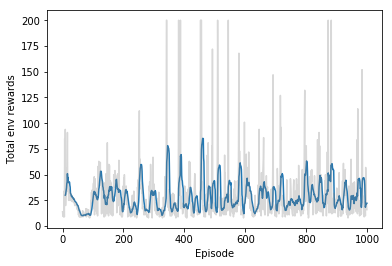

In [47]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total env rewards')

Text(0,0.5,'Total actions logits rewards')

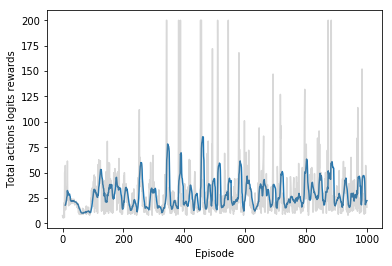

In [48]:
eps, arr = np.array(rewards2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions logits rewards')

Text(0,0.5,'Total actions labels/onehot rewards')

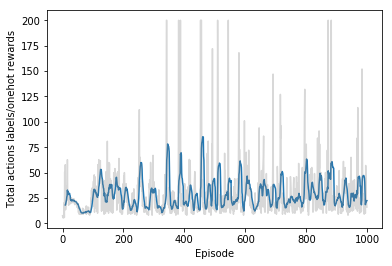

In [49]:
eps, arr = np.array(rewards3_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions labels/onehot rewards')

Text(0,0.5,'Gloss')

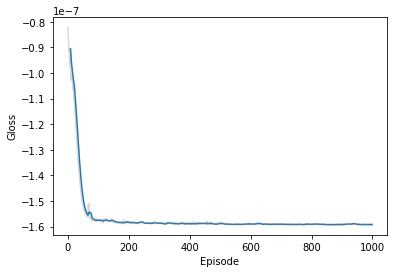

In [50]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Gloss')

Text(0,0.5,'Dloss')

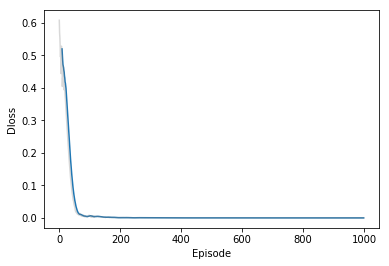

In [51]:
eps, arr = np.array(d_loss_fake_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Dloss')

Text(0,0.5,'Dloss')

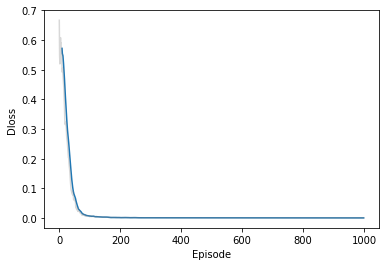

In [18]:
eps, arr = np.array(d_loss_real_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Dloss')